Start with a simple multi-stage autoencoder.

Uses asinh/sinh as invertible activation function pair. Took some hacking to avoid nan loss!

https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import nn
import keras
from keras import layers
from keras.datasets import mnist


In [2]:

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [3]:
def create_model():
    input_img = keras.Input(shape=(784,))
    encoded = layers.Dense(128, activation='sigmoid')(input_img)
    encoded = layers.Dense(64, activation='sigmoid')(encoded)
    encoded = layers.Dense(32, activation='sigmoid')(encoded)

    decoded = layers.Dense(64, activation='sigmoid')(encoded)
    decoded = layers.Dense(128, activation='sigmoid')(decoded)
    decoded = layers.Dense(784, activation='sigmoid')(decoded)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mae')
    autoencoder.summary()
    return autoencoder


In [4]:
num_epochs = 10
autoencoder = create_model()

autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 784)               101136

In [5]:
# https://github.com/nanopony/keras-convautoencoder/blob/master/autoencoder_layers.py
class DependentForward(layers.Dense):
    def __init__(self, output_dim, master_layer, input_dim=None, **kwargs):
        self.master_layer = master_layer
        super(DependentDense,self).__init__(output_dim, **kwargs)

    def build(self):
        self.W = self.master_layer.W.T
        self.params = []


In [6]:
class DependentBias(layers.Layer):
    def __init__(self, master_layer, **kwargs):
        self.master_layer = master_layer
        super(DependentBias,self).__init__(**kwargs)

    def call(self, inputs):
        out = inputs - self.master_layer.b
        print('call: out', out)
        return out


In [31]:
def linear(x):
  return x

def sinh(x):
    return tf.math.sinh(x + 0.00001)

def asinh(x):
    return tf.math.asinh(x - 0.00001)

inverses = { 'sinh': asinh, 'asinh': sinh, sinh: asinh, asinh: sinh}

In [32]:
values = tf.Variable(np.asarray((np.arange(50) - 25)/10))
print(values)
for act in [sinh, asinh]:
    inverted = act(values)
    print('inverted', inverted)
    print('delta', values - inverted)

<tf.Variable 'Variable:0' shape=(50,) dtype=float64, numpy=
array([-2.5, -2.4, -2.3, -2.2, -2.1, -2. , -1.9, -1.8, -1.7, -1.6, -1.5,
       -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4,
       -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,
        0.8,  0.9,  1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,
        1.9,  2. ,  2.1,  2.2,  2.3,  2.4])>
inverted tf.Tensor(
[-6.05014316e+00 -5.46617364e+00 -4.93691143e+00 -4.45705949e+00
 -4.02181530e+00 -3.62682279e+00 -3.26812873e+00 -2.94214321e+00
 -2.64560365e+00 -2.37554218e+00 -2.12925593e+00 -1.90427999e+00
 -1.69836273e+00 -1.50944325e+00 -1.33563079e+00 -1.17518576e+00
 -1.02650239e+00 -8.88092608e-01 -7.58571150e-01 -6.36641728e-01
 -5.21084029e-01 -4.10741515e-01 -3.04509840e-01 -2.01325802e-01
 -1.00156700e-01  1.00000000e-05  1.00176800e-01  2.01346203e-01
  3.04530747e-01  4.10763137e-01  5.21106582e-01  6.36665437e-01
  7.58596254e-01  8.88119357e-01  1.02653106e+00  1.17521662e+0

In [33]:
class TiedDense(layers.Layer):
    global inverses
    def __init__(self, master_layer):
        super(TiedDense, self).__init__()
        self.master_layer = master_layer

    def build(self, input_shape):
        activation = self.master_layer.get_config()['activation']
        print('activation', activation)
        self.inverse_activation = inverses[activation]
        print('inverse_activation', self.inverse_activation)
        # do not train weights or bias from master_layer, they are read-only
        self.params = []
        
    def call(self, inputs):  # Defines the computation from inputs to outputs
        W = self.master_layer._trainable_weights[0]
        b = self.master_layer._trainable_weights[1]
        w = tf.transpose(W)
        return tf.matmul(self.inverse_activation(inputs) - b, w)
    

In [51]:
def create_palindromic_model(activation_forward):
    input_img = keras.Input(shape=(784,))
    # crushed = layers.Activation(activation=activation_forward)(input_img)
    a = layers.Dense(128, activation=activation_forward)
    encoded = a(input_img)
    encoded = layers.Dropout(0.2)(encoded)
    b = layers.Dense(64, activation=activation_forward)
    encoded = b(encoded)
    c = layers.Dense(32, activation=activation_forward)
    embedding = c(encoded)
    # embedding = layers.Dropout(0.2)(embedding)

    decoded = TiedDense(c)(embedding)
    decoded = TiedDense(b)(decoded)
    decoded = TiedDense(a)(decoded)
    decoded = layers.Activation(activation='sigmoid')(decoded)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    # autoencoder.layers[-1].trainable = False
    # autoencoder.layers[-2].trainable = False
    # autoencoder.layers[-3].trainable = False
    return autoencoder


In [55]:
activation_forward = asinh
num_epochs = 50
autoencoder = create_palindromic_model(activation_forward)

autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


activation asinh
inverse_activation <function sinh at 0x7f164db59dd0>
activation asinh
inverse_activation <function sinh at 0x7f164db59dd0>
activation asinh
inverse_activation <function sinh at 0x7f164db59dd0>
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_51 (Dense)            (None, 128)               100480    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_52 (Dense)            (None, 64)                8256      
                                                                 
 dense_53 (Dense)            (None, 32)                2080      
                                              

In [56]:

predicted_imgs = autoencoder.predict(x_test)
# decoded_imgs = autoencoder.predict(encoded_imgs)

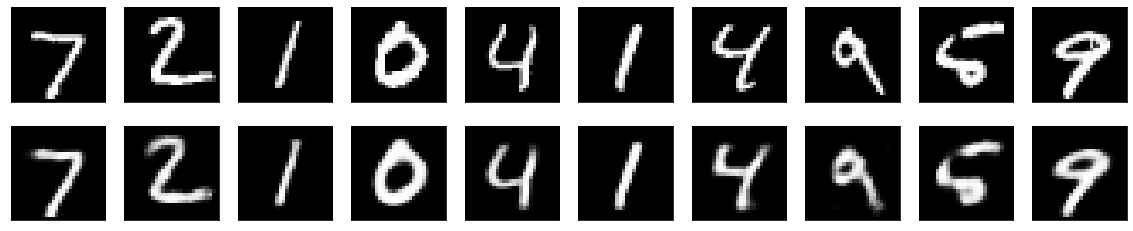

In [57]:
# Use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
